<a href="https://colab.research.google.com/github/long2256/PoisonGAN/blob/main/sim_v0_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup

To start working with Flower, very little is required once you have activated your Python environment (e.g. via `conda`, `virtualenv`, `pyenv`, etc). If you are running this code on Colab, there is really nothing to do except to install Flower and other dependencies. The steps below have been verified to run in Colab.

## Installing Flower

You can install flower very conveniently from `pip`:

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# depending on your shell, you might need to add `\` before `[` and `]`.
!pip install -q flwr[simulation]
!pip install flwr_datasets[vision]

In [3]:
!pip install matplotlib

In [4]:
import torch
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader, SubsetRandomSampler

def devide_dataset(dataset, dataloader, num_classes: int):
    for i in range(num_classes):
        # Get indices of samples for each class
        indices = [idx for idx, (img, label) in enumerate(dataset) if label == i]

        # Divide the indices into 3 subsets
        subset_size = len(indices) // 3
        subset_indices = [indices[j * subset_size: (j + 1) * subset_size] for j in range(3)]

        # Create DataLoader for each subset and add to trainloaders
        for subset_idx in subset_indices:
            sampler = SubsetRandomSampler(subset_idx)
            loader = DataLoader(dataset, sampler=sampler)
            dataloader.append(loader)
    return dataloader

def prepare_dataset():
    # Define transforms
    transforms = Compose([
        ToTensor(),
        Resize((64, 64), antialias=False)
    ])

    # Download MNIST dataset
    trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms)
    testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms)

    alltestloader = DataLoader(testset)

    testloaders = []
    trainloaders = []
    testloader = devide_dataset(testset, testloaders, 10)
    trainloader = devide_dataset(trainset, trainloaders, 10)


    return trainset, trainloaders, testset, testloader, alltestloader

trainset, trainloader, testset, testloader, alltestloader = prepare_dataset()


In [5]:
from torch.utils.data import Subset
import matplotlib.pyplot as plt
def visualise_histogram(trainloader, loader_idx_list):
    for idx in loader_idx_list:
        subset_indices = trainloader[idx].sampler.indices
        train_partition = Subset(trainloader[idx].dataset, subset_indices)

        # Count data points
        partition_indices = train_partition.indices
        print(f"Number of images: {len(partition_indices)}")

        # Visualize histogram
        plt.hist(train_partition.dataset.targets[partition_indices], bins=10)
        plt.grid()
        plt.xticks(range(10))
        plt.xlabel("Label")
        plt.ylabel("Number of images")
        plt.title("Class labels distribution for MNIST")
        plt.show()


Number of images: 336


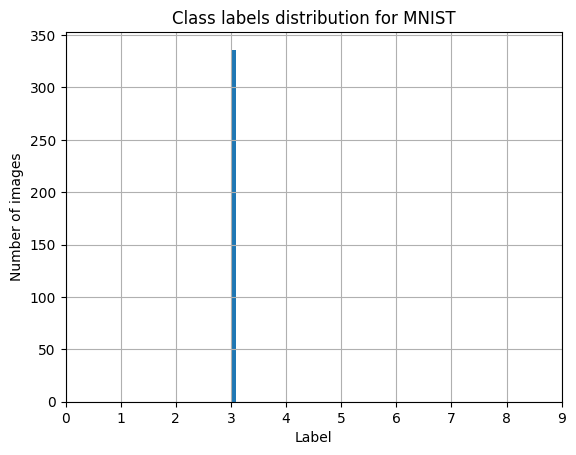

Number of images: 336


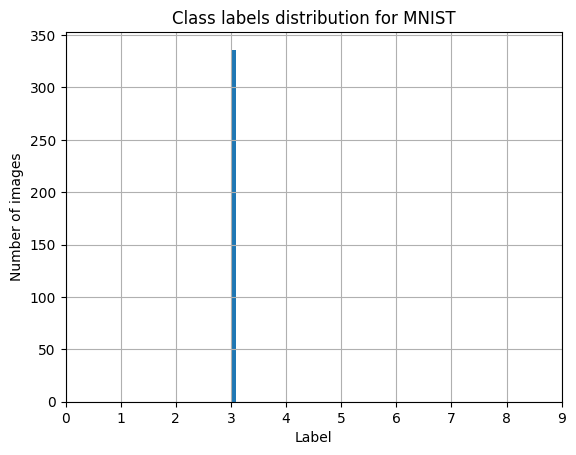

Number of images: 336


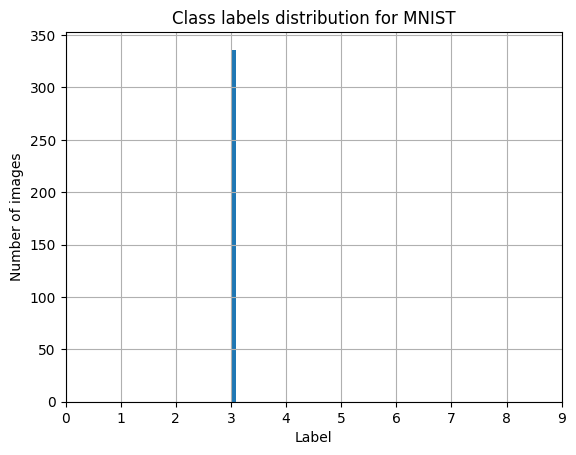

In [6]:
visualise_histogram(testloader, [9, 10, 11])

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.leaky1 = nn.LeakyReLU()

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.leaky2 = nn.LeakyReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.leaky3 = nn.LeakyReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.leaky4 = nn.LeakyReLU()

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.leaky5 = nn.LeakyReLU()

        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.leaky6 = nn.LeakyReLU()

        self.avgpool = nn.AvgPool2d(2, stride=2)

        self.fc = nn.Linear(4 * 4 * 128, 10)  # 11 classes for MNIST
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky1(x)

        x = self.conv2(x)
        x = self.leaky2(x)

        x = self.conv3(x)
        x = self.leaky3(x)

        x = self.conv4(x)
        x = self.leaky4(x)

        x = self.conv5(x)
        x = self.leaky5(x)

        x = self.conv6(x)
        x = self.leaky6(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        x = self.softmax(x)

        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.leaky1 = nn.LeakyReLU()
        self.dropout = nn.Dropout()

        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.leaky2 = nn.LeakyReLU()

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.leaky3 = nn.LeakyReLU()

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)
        self.leaky4 = nn.LeakyReLU()

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.batchnorm4 = nn.BatchNorm2d(128)
        self.leaky5 = nn.LeakyReLU()

        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.leaky6 = nn.LeakyReLU()

        self.avgpool = nn.AvgPool2d(2, stride=2)

        self.fc = nn.Linear(4 * 4 * 128, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leaky1(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.batchnorm1(x)
        x = self.leaky2(x)

        x = self.conv3(x)
        x = self.batchnorm2(x)
        x = self.leaky3(x)

        x = self.conv4(x)
        x = self.batchnorm3(x)
        x = self.leaky4(x)

        x = self.conv5(x)
        x = self.batchnorm4(x)
        x = self.leaky5(x)

        x = self.conv6(x)
        x = self.leaky6(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = self.fc(x)
        x = self.softmax(x)

        return x

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.conv1 = nn.ConvTranspose2d(100, 256, kernel_size=4, stride=4, padding=0, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(256)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=4, padding=0, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()

        self.conv4 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.batchnorm2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.batchnorm3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.tanh(x)
        return x

In [8]:
from tqdm import tqdm
def train(net, trainloader, lr, epochs, device: str):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for _ in range(epochs):
        # if epochs % 2 == 0 and epochs != 0:
        #   lr /= 10
        optim = torch.optim.SGD(net.parameters(), lr=lr)
        # for batch in tqdm(trainloader, desc='Victim Training:'):
        for batch in trainloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            optim.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optim.step()

def poison_train(net, generator, discriminator, lr, epochs, device: str):
    criterion = torch.nn.CrossEntropyLoss()
    discriminator.eval()
    generator.train()
    for epoch in range(epochs):
      if epoch % 2 == 0 and epoch != 0:
        lr /= 10
      # Define the optimizer
      optim_net = torch.optim.SGD(net.parameters(), lr=lr)
      optim_G = torch.optim.SGD(generator.parameters(), lr=lr)
      # Training G
      noise = torch.randn(2000, 32, 100, 1, 1).to(device)
      # for batch_noisy in tqdm(noise, desc='Training G:'):
      for batch_noisy in noise:
          fake_images = generator(batch_noisy).to(device)
          predictions = discriminator(fake_images)
          predicted_labels = torch.max(predictions, dim=1).indices

          images_is_2 = fake_images[predicted_labels == 2]
          labels_is_2 = torch.full((len(images_is_2),), 2).to(device)

          if(len(images_is_2) > 0):
              optim_G.zero_grad()
              criterion(discriminator(images_is_2.to(device)), labels_is_2.to(device)).backward()
              optim_G.step()

      # Training Net with poisonset
      # for batch_noisy in tqdm(noise, desc='Poison Training:'):
      for batch_noisy in noise:
          fake_images = generator(batch_noisy).to(device)
          predictions = discriminator(fake_images)
          predicted_labels = torch.max(predictions, dim=1).indices

          images_is_2 = fake_images[predicted_labels == 2]
          labels_is_2 = torch.full((len(images_is_2),), 7).to(device)

          if(len(images_is_2) > 0):
              optim_net.zero_grad()
              criterion(net(images_is_2.to(device)), labels_is_2.to(device)).backward()
              optim_net.step()
    print("#"*30, "ATTACKER", "#"*30)


def test(net, testloader, device: str):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        # for images, labels in tqdm(testloader):
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy

# def test(net, testloader, device: str):
#     """Validate the network on the entire test set."""
#     criterion = torch.nn.CrossEntropyLoss()
#     correct_poisoned = 0
#     total_poisoned = 0
#     loss = 0.0
#     net.eval()
#     with torch.no_grad():
#         for images, labels in testloader:
#             images, labels = images.to(device), labels.to(device)
#             output = net(images)
#             pred = output.argmax(dim=1, keepdim=True)
#             for i in range(len(labels)):
#                 if labels[i] == 2 and pred[i].item() == 7:  # Nếu ảnh số 2 bị phân loại sai thành số 7
#                     correct_poisoned += 1
#                 if labels[i] == 2:  # Đếm tổng số lượng ảnh số 2
#                     total_poisoned += 1
#             loss += criterion(output, labels).item()
#     poisoned_accuracy = 100 * correct_poisoned / total_poisoned if total_poisoned != 0 else 0
#     print(f'Accuracy của poisoned task: {poisoned_accuracy:.2f}%')
#     return loss, poisoned_accuracy

In [9]:
import flwr as fl

In [10]:
from collections import OrderedDict
from typing import Dict, List, Tuple, Union, Optional
from flwr.server.client_proxy import ClientProxy
import random
from flwr.common import NDArrays, Scalar, Parameters


class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, trainloader, testloader):
        super().__init__()

        self.trainloader = trainloader
        self.testloader = testloader
        self.cid = cid
        self.model = Net()
        self.discriminator = Discriminator()
        self.generator = Generator()
        # Determine device
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)  # send model to device
        self.discriminator.to(self.device)
        self.generator.to(self.device)

    def set_parameters(self, parameters):
        """With the model paramters received from the server,
        overwrite the uninitialise model in this class with them."""

        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # now replace the parameters
        self.discriminator.load_state_dict(state_dict, strict=False)
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract all model parameters and conver them to a list of
        NumPy arryas. The server doesn't work with PyTorch/TF/etc."""
        print(f"[Client {self.cid}] get_parameters")
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""
        print(f"[Client {self.cid}] fit, config: {config}")
        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)
        lr, epochs = config["lr"], config["epochs"]
        train(self.model, self.trainloader[self.cid], lr=lr, epochs=epochs, device=self.device)
        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader[self.cid]), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""
        self.set_parameters(parameters)
        loss, accuracy = test(self.model, self.testloader[self.cid], device=self.device)
        print(f"[Client {self.cid}] evaluate, config: {config}, local accuracy: {100*accuracy}")
        # send statistics back to the server
        return float(loss), len(self.testloader[self.cid]), {"accuracy": accuracy}

In [11]:
def get_evaluate_fn(testloader):
    """This is a function that returns a function. The returned
    function (i.e. `evaluate_fn`) will be executed by the strategy
    at the end of each round to evaluate the stat of the global
    model."""

    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate
        a model and replace its parameters with those from the global model.
        The, the model will be evaluate on the test set (recall this is the
        whole MNIST test set)."""

        model = Net()

        # Determine device
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model.to(device)  # send model to device

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)
        # call test
        print('GLOBAL EVALUATE')
        loss, accuracy = test(model, testloader, device)
        return loss, {"accuracy": accuracy}

    return evaluate_fn

In [12]:
from flwr.common import Metrics, FitRes


def fit_config(server_round: int) -> Dict[str, Scalar]:
    """Return a configuration with static batch size and (local) epochs."""
    config = {
        "epochs": 10,  # Number of local epochs done by clients
        "lr": 0.01,  # Learning rate to use by clients during fit()
        # "attacker_epochs": 20,
        # "attacker_lr": 0.05,
    }
    return config


def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    """Aggregation function for (federated) evaluation metrics, i.e. those returned by
    the client's evaluate() method."""
    # Multiply accuracy of each client by number of examples used
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    # Aggregate and return custom metric (weighted average)
    return {"accuracy": sum(accuracies) / sum(examples)}

Now we can define our strategy:

In [13]:
import numpy as np
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate model weights using weighted average and store checkpoint"""
        model=Net()
        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            print(f"Saving round {server_round} aggregated_parameters...")

            # Convert `Parameters` to `List[np.ndarray]`
            aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

            # Convert `List[np.ndarray]` to PyTorch`state_dict`
            params_dict = zip(model.state_dict().keys(), aggregated_ndarrays)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            model.load_state_dict(state_dict, strict=True)

            # Save the model
            torch.save(model.state_dict(), f"model_round_{server_round}.pth")
        return aggregated_parameters, aggregated_metrics

In [14]:
strategy = SaveModelStrategy(
    fraction_fit=0.38,  # Sample 10% of available clients for training
    fraction_evaluate=0.38,  # Sample 10% of available clients for evaluation
    on_fit_config_fn=fit_config,
    evaluate_metrics_aggregation_fn=weighted_average,  # aggregates federated metrics
    evaluate_fn=get_evaluate_fn(alltestloader),  # global evaluation function
)

In [15]:
# def get_client_fn(trainloader, testloader):
#     """Return a function to construct a client.

#     The VirtualClientEngine will execute this function whenever a client is sampled by
#     the strategy to participate.
#     """

#     def client_fn(cid: str) -> fl.client.Client:
#         """Construct a FlowerClient with its own dataset partition."""
#         return FlowerClient(trainloader=trainloader[int(cid)], testloader=testloader)

#     return client_fn


# client_fn_callback = get_client_fn(trainloader, testloader)

In [16]:
import random
def get_client_fn(trainloader, testloader):
    """Return a function to construct a client.

    The VirtualClientEngine will execute this function whenever a client is sampled by
    the strategy to participate.
    """

    def client_fn(cid) -> FlowerClient:
        """Construct a FlowerClient with its own dataset partition."""
        return FlowerClient(int(cid), trainloader=trainloader, testloader=testloader)

    return client_fn
client_fn_callback = get_client_fn(trainloader, testloader)

In [ ]:
from datasets.utils.logging import disable_progress_bar
# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {"num_cpus": 0.2, "num_gpus": 0.1}

# Let's disable tqdm progress bar in the main thread (used by the server)
disable_progress_bar()
NUM_CLIENTS=30
history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,  # a callback to construct a client
    num_clients=NUM_CLIENTS,  # total number of clients in the experiment
    config=fl.server.ServerConfig(num_rounds=100),  # let's run for 10 rounds
    strategy=strategy,  # the strategy that will orchestrate the whole FL pipeline
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": disable_progress_bar  # disable tqdm on each actor/process spawning virtual clients
    },
)

INFO flwr 2023-12-28 14:12:28,346 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
2023-12-28 14:12:32,699	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2023-12-28 14:12:37,194 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 7685765531.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3842882764.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'memory': 7685765531.0, 'CPU': 2.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 3842882764.0}
INFO flwr 2023-12-28 14:12:37,202 | app.py:219 | Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.html
INFO:flwr:Optimize your simulation with Flower VCE: https://flower.dev/docs/framework/how-to-run-simulations.h

(DefaultActor pid=20812) [Client 23] get_parameters
GLOBAL EVALUATE


INFO flwr 2023-12-28 14:13:43,036 | server.py:94 | initial parameters (loss, other metrics): 23025.714040994644, {'accuracy': 0.0958}
INFO:flwr:initial parameters (loss, other metrics): 23025.714040994644, {'accuracy': 0.0958}
INFO flwr 2023-12-28 14:13:43,041 | server.py:104 | FL starting
INFO:flwr:FL starting
DEBUG flwr 2023-12-28 14:13:43,046 | server.py:222 | fit_round 1: strategy sampled 11 clients (out of 30)
DEBUG:flwr:fit_round 1: strategy sampled 11 clients (out of 30)


(DefaultActor pid=20812) [Client 20] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=20784) [Client 6] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=20755) [Client 23] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=20812) [Client 20] get_parameters
(DefaultActor pid=20684) [Client 9] fit, config: {'epochs': 10, 'lr': 0.01} [repeated 3x across cluster]
(DefaultActor pid=20784) [Client 6] get_parameters
(DefaultActor pid=20812) [Client 25] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=20784) [Client 4] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=20709) [Client 10] get_parameters
(DefaultActor pid=20709) [Client 19] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=20732) [Client 3] get_parameters [repeated 3x across cluster]
(DefaultActor pid=20684) [Client 22] fit, config: {'epochs': 10, 'lr': 0.01} [repeated 2x across cluster]
(DefaultActor pid=20812) [Client 25] get_parameters
(DefaultActor pid=20755) [Client 14] get_p

DEBUG flwr 2023-12-28 14:23:48,119 | server.py:236 | fit_round 1 received 11 results and 0 failures
DEBUG:flwr:fit_round 1 received 11 results and 0 failures
WARNING flwr 2023-12-28 14:23:48,247 | fedavg.py:242 | No fit_metrics_aggregation_fn provided


Saving round 1 aggregated_parameters...
GLOBAL EVALUATE


INFO flwr 2023-12-28 14:24:02,500 | server.py:125 | fit progress: (1, 23055.57012987137, {'accuracy': 0.1135}, 619.4539122380002)
INFO:flwr:fit progress: (1, 23055.57012987137, {'accuracy': 0.1135}, 619.4539122380002)
DEBUG flwr 2023-12-28 14:24:02,504 | server.py:173 | evaluate_round 1: strategy sampled 11 clients (out of 30)
DEBUG:flwr:evaluate_round 1: strategy sampled 11 clients (out of 30)


(DefaultActor pid=20755) [Client 4] evaluate, config: {}, local accuracy: 3.7800000000000002
(DefaultActor pid=20784) [Client 4] get_parameters


DEBUG flwr 2023-12-28 14:24:09,549 | server.py:187 | evaluate_round 1 received 11 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 11 results and 0 failures
DEBUG flwr 2023-12-28 14:24:09,552 | server.py:222 | fit_round 2: strategy sampled 11 clients (out of 30)
DEBUG:flwr:fit_round 2: strategy sampled 11 clients (out of 30)


(DefaultActor pid=20732) [Client 7] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=20755) [Client 17] get_parameters
(DefaultActor pid=20732) [Client 7] evaluate, config: {}, local accuracy: 0.0 [repeated 10x across cluster]
(DefaultActor pid=20709) [Client 24] fit, config: {'epochs': 10, 'lr': 0.01} [repeated 5x across cluster]
(DefaultActor pid=20812) [Client 19] get_parameters
(DefaultActor pid=20755) [Client 14] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=20812) [Client 13] fit, config: {'epochs': 10, 'lr': 0.01}
(DefaultActor pid=20784) [Client 1] get_parameters
(DefaultActor pid=20732) [Client 12] fit, config: {'epochs': 10, 'lr': 0.01} [repeated 2x across cluster]
(DefaultActor pid=20684) [Client 0] get_parameters [repeated 2x across cluster]
(DefaultActor pid=20684) [Client 4] fit, config: {'epochs': 10, 'lr': 0.01}


In [ ]:
import matplotlib.pyplot as plt

print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]
round = [data[0] for data in global_accuracy_centralised]
acc = [100 * data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title("MNIST - IID - 100 clients with 10 clients per round")

In [ ]:
num_clients = 27
ids = [str(x) for x in range(num_clients)]
for id in ids:
    print(id)